# Introduction

The goals of this analysis is to train, optimize, predict, evaluate, and SHAP BPNet and ChromBPNet models using BPReveal, the reimplementation of BPNet developed by Charles McAnany.

We will also train a 3-fold validation model post-optimization to ensure that training/validation/test datasets are stable across models.

The three model paradigms will be as follows:

1. BPNet on five TFs: Oct4, Sox2, Nanog, Klf4, and Zic3 in mESC R1 cell line
2. ChromBPNet on ATAC-seq wildtype in mESC R1 cell line
3. ChromBPNet on six timepoints of ATAC-seq experiments conducted during depletion of Oct4 over time.

# Computational setup

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import warnings
warnings.filterwarnings("ignore")
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

#Packages
import os
import sys
import keras
import pyBigWig
import json
import pandas as pd
import numpy as np
import keras.backend as K
from keras.models import load_model
from tqdm import tqdm
import glob


import plotnine
from plotnine import *

# Settings

## Working options
os.chdir(f'/n/projects/mw2098/publications/2024_weilert_acc/code/2_analysis/')
pd.set_option('display.max_columns', 100)
figure_path = 'figures/3_train_models'
bpreveal_path = '/n/projects/mw2098/publications/2024_weilert_acc/public/software/bpreveal_404/'
python_path = '/home/mw2098/anaconda3/envs/bpreveal_404/bin/python'

## Custom functions
sys.path.insert(0, f'scripts/py/functions')
from metrics import compute_auprc
from functional import one_hot_encode_sequences, one_hot_encode_sequence, one_hot_decode_sequence, shuffle_seqs, logitsToProfile, insert_motif
from perturb import generate_random_seq
from motifs import extract_seqs_from_df, resize_coordinates

sys.path.insert(0, f'{bpreveal_path}/src')
import losses

## Filesystem commands
!mkdir -p \
    json/optimize \
    bed/bpreveal/optimize \
    input/optimize \
    models/optimize \
    preds/optimize \
    scripts/optimize \
    tsv/optimize \
    shap \
    npz \
    {figure_path}

2024-06-25 13:04:08.314253: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 13:04:08.314308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 13:04:08.315554: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-25 13:04:08.322679: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 13:04:09.974884: W tensorflow/comp

# Set up static variables

Here are the variables that will remain static throughout the optimization process. 

In [2]:
# Default model architecture
output_length = 1000
max_jitter = 100
batch_size = 64
learning_rate = 0.004 #BPReveal is adaptive, so this learning rate doesn't need optimizing.
early_stopping_patience = 8
reverse_complement = True
seed = 2346
trials = 256

#Annotations
genome = '../0_setup/fa/mm10.fa'
test_chroms = ['chr1', 'chr8', 'chr17']
val_chroms = ['chr2', 'chr3', 'chr9']
train_chroms = ['chr4', 'chr5', 'chr6', 'chr7', 'chr10', 'chr11', 'chr12', 'chr13', 
                'chr14', 'chr15', 'chr16', 'chr18', 'chr19', 'chrX']
profile_metrics_of_interest = ['mnll', 'jsd']
counts_metrics_of_interest = ['counts-pearson', 'counts-spearman']

# Modeling data and setup
region_dict = {'oct4': 'narrowpeak/mesc_oct4_nexus_peaks.narrowPeak',
               'sox2': 'narrowpeak/mesc_sox2_nexus_peaks.narrowPeak',
               'klf4': 'narrowpeak/mesc_klf4_nexus_peaks.narrowPeak',
               'nanog': 'narrowpeak/mesc_nanog_nexus_peaks.narrowPeak',
               'zic3': 'narrowpeak/mesc_zic3_nexus_peaks.narrowPeak'}
bias_regions_path = 'narrowpeak/mesc_atac_non_peaks.narrowPeak'
concentration_atac_timepoints = list(range(0, 16, 3))


modeling_design_dict = {
    # 'bpnet_osknz':{
    #     'tasks': list(region_dict.keys()),
    #     'cov': {k: {'pos': 'bw/mesc_' + k + '_nexus_combined_positive.bw',
    #                 'neg': 'bw/mesc_' + k + '_nexus_combined_negative.bw'}
    #             for k in region_dict.keys()},
    #     'num-channels': 2
    # },
    'atac_wt':{
        'tasks': ['atac'],
        'cov': 'bw/mesc_native_atac_cutsites_combined.bw',
        'num-channels': 1
    }
}

working_dir = os.getcwd()
gpu_header = ['#!/usr/bin/bash',
              '#SBATCH --job-name bpnet_training',
              '#SBATCH --output=slurm_%j.log',
              '#SBATCH --mem=200gb', '#SBATCH --time=72:00:00',
              '#SBATCH --partition=gpu', '#SBATCH --gres=gpu:a100:1',
              '#SBATCH --cpus-per-task=10',
              'source /home/mw2098/.bashrc',
              'conda deactivate',
              'conda activate bpreveal_404',
              f'cd {working_dir}']

In [3]:
modeling_design_dict

{'atac_wt': {'tasks': ['atac'],
  'cov': 'bw/mesc_native_atac_cutsites_combined.bw',
  'num-channels': 1}}

# Set up dynamic variables

Assign variable sets for different optimization sets. When we optimize, we will be simply optimizing from the default BPNet architecture independently for each parameter, then training a final model that concatenates these optimizations (ensuring that the final model is the best, of course). When we are optimizing, we know that BPNet is highly stable with its performance from Avsec et al 2021, and that ChromBPNet is stable from Brennan and Weilert et al 2023, regardless of architectural changes. However, we are doing our due diligence here to ensure that this remains the case for our specific models.  

In [4]:
#Default BPNet parameters
default_dict = {
    'n_dil_layers' : 9,
    'conv1_kernel_size' : 25,
    'profile_kernel_size' : 25,
    'filters' : 64,
    'counts_loss_weight' : 10
}

#Parameters being tested for model performance
opt_dict = {
    'n_dil_layers' : [7, 8, 9, 10, 11], 
    'conv1_kernel_size' : [7, 51], 
    'profile_kernel_size' : [7, 51], 
    'filters' : [16, 128, 256], 
    'counts_loss_weight' : [1, 100, 1000, 10000] 
}

#Parameters required of the bias model
bias_dict = {
    'n_dil_layers' : 4,
    'conv1_kernel_size' : 21,
    'profile_kernel_size' : 75,    
    'filters' : 128,
    'counts_loss_weight' : 10    
}

## Assign synced `input_seqlen`

Here we will decide on a model size based on the complexity of our expected problem through the optimization steps. Using `lengthCalc.py`, this will help us understand how to design a properly spaced input set for the dilated convolutions.

In [5]:
input_lengths_dict = {}
for param_name, param_values in opt_dict.items():
    input_lengths_list = []
    for param_value in param_values:
        
        #Overwrite parameter in appropriate field
        current_settings_dict = default_dict.copy()
        current_settings_dict[param_name] = param_value
        
        #Calculate the input seqlen
        input_length = !{bpreveal_path}/src/lengthCalc.py \
        --output-len {output_length} \
        --n-dil-layers {current_settings_dict['n_dil_layers']} \
        --conv1-kernel-size {current_settings_dict['conv1_kernel_size']} \
        --profile-kernel-size {current_settings_dict['profile_kernel_size']}
        
        #Assign to dictionary with same dimensions as default_dict
        input_length = int(input_length[0])
        input_lengths_list.append(input_length)
        
    input_lengths_dict[param_name] = input_lengths_list
input_lengths_dict

{'n_dil_layers': [1556, 2068, 3092, 5140, 9236],
 'conv1_kernel_size': [3074, 3118],
 'profile_kernel_size': [3074, 3118],
 'filters': [3092, 3092, 3092],
 'counts_loss_weight': [3092, 3092, 3092, 3092]}

# Set up data

Since we have already prepared our .bw and .narrowpeak files, we now need to convert the training, validation, and test data into results that can be processed.

## Prepare region and coverage information for optimization training

1. Prepare a `.json` file to denote how we want to split and process our regions. 
2. Export the .bw files to .hdf5 files to be compatible with the training paradigm of BPReveal.
    + Do this for training and validation sets.

In [6]:
#Prepare .bw configurations. Remember, order matters here.
modeling_cov_dict = {}
for k,v in modeling_design_dict.items():
    bw_dict = {}
    if type(v['cov'])==str:
        bw_dict['prepare_bed_inputs'] = [{'bigwig-names': [v['cov']], 'max-quantile': 1, 'min-counts': 1}]
        bw_dict['prepare_train_inputs'] = [{'bigwig-files': [v['cov']], 'revcomp-task-order': 'auto'}]
    else:
        bw_dict['prepare_bed_inputs'] = [{'bigwig-names': list(v2.values()), 'max-quantile': 1, 'min-counts': 1} for v2 in v['cov'].values()]
        bw_dict['prepare_train_inputs'] = [{'bigwig-files': list(v2.values()), 'revcomp-task-order': 'auto'} for v2 in v['cov'].values()]
    modeling_cov_dict[k] = bw_dict
modeling_cov_dict

{'atac_wt': {'prepare_bed_inputs': [{'bigwig-names': ['bw/mesc_native_atac_cutsites_combined.bw'],
    'max-quantile': 1,
    'min-counts': 1}],
  'prepare_train_inputs': [{'bigwig-files': ['bw/mesc_native_atac_cutsites_combined.bw'],
    'revcomp-task-order': 'auto'}]}}

# Train BPNet model to assess best performance

Next, we will train, predict, and assess the different BPNet models to select the best parameters for optimization. Then we will train based on the best parameters and verify that the optimization is appropriate.

First, set up the different json files to train, predict, and assess the model.

## Generate `input.h5` data for optimization training

Define data required for our optimizations. This will change based on the required input receptive field derived from the model depth. 

In [7]:
input_lengths_all = list(set([item for sublist in [v for v in input_lengths_dict.values()] for item in sublist]))
input_lengths_all

[3074, 3118, 3092, 9236, 1556, 2068, 5140]

Prepare .bed files in order to train and allocate data.

In [8]:
%%script false --no-raise-error

#Loop through different input_lengths based on the different model requirements to generate data.
for model_name,model_bws in modeling_cov_dict.items():
    for input_length in input_lengths_all:
        param_prefix = model_name + '_' + str(input_length)
    
        #Consolidate into a .json-readable dictionary
        prepare_bed_regions_dict = {'heads': model_bws['prepare_bed_inputs'],
                                    'splits': {"test-chroms": test_chroms, 
                                               "val-chroms": val_chroms,
                                               "train-chroms": train_chroms,
                                               "regions": list(region_dict.values())},
                                    'genome': f'{genome}',
                                    'write-counts-to': f'bed/bpreveal/optimize/{param_prefix}_all.stats',
                                    'output-length': output_length,
                                    'input-length': input_length,
                                    'max-jitter': max_jitter,
                                    'output-prefix': f'bed/bpreveal/optimize/{param_prefix}',
                                    'resize-mode': 'center',
                                    'remove-overlaps': False,
                                    'verbosity': 'INFO'} #Switch this to DEBUG if you are missing regions
    
        #Write that json.
        prepare_bed_regions_json = json.dumps(prepare_bed_regions_dict, indent=4)
    
        # Writing to sample.json
        bed_json_file = f'json/optimize/prepareBedPeaks_{param_prefix}.json'
        
        with open(bed_json_file, 'w') as outfile:
            outfile.write(prepare_bed_regions_json)

        # Run the code to prepare peaks.
        !{python_path} {bpreveal_path}/src/prepareBed.py {bed_json_file}

Prepare the input data as .h5 files.

In [9]:
%%script false --no-raise-error

#Loop through different input_lengths based on the different model requirements to generate data.
for model_name,model_bws in modeling_cov_dict.items():
    for input_length in input_lengths_all:
        param_prefix = model_name + '_' + str(input_length)
    
        # Prepare input training data
        prepare_input_train_dict = {'genome': genome, 
                            'input-length': input_length, 
                            'output-length': output_length, 
                            'max-jitter': max_jitter, 
                            'regions': f'bed/bpreveal/optimize/{param_prefix}_train.bed', 
                            'output-h5': f'input/optimize/{param_prefix}_train.h5', 
                            'heads': model_bws['prepare_train_inputs'], 
                            'reverse-complement': reverse_complement,
                            'verbosity': 'DEBUG'} 
        prepare_input_train_json = json.dumps(prepare_input_train_dict, indent=4)
        train_json_file = f'json/optimize/prepareInputTrain_{param_prefix}.json'        
        with open(train_json_file, 'w') as outfile:
            outfile.write(prepare_input_train_json)
        !{python_path} {bpreveal_path}/src/prepareTrainingData.py {train_json_file}
            
        # Prepare validation training data
        prepare_input_valid_dict = {'genome': genome, 
                    'input-length': input_length, 
                    'output-length': output_length, 
                    'max-jitter': max_jitter, 
                    'regions': f'bed/bpreveal/optimize/{param_prefix}_val.bed', 
                    'output-h5': f'input/optimize/{param_prefix}_val.h5', 
                    'heads': model_bws['prepare_train_inputs'], 
                    'reverse-complement': reverse_complement,
                    'verbosity': 'DEBUG'} 
        prepare_input_valid_json = json.dumps(prepare_input_valid_dict, indent=4)
        valid_json_file = f'json/optimize/prepareInputValid_{param_prefix}.json'        
        with open(valid_json_file, 'w') as outfile:
            outfile.write(prepare_input_valid_json)
        !{python_path} {bpreveal_path}/src/prepareTrainingData.py {valid_json_file}

## Generate `input.h5` data for ChromBPNet bias training

Define data required for our optimized timepoint.

### Determine Tn5 bias input length

In [10]:
#Set up features.
bias_prefix = 'atac_bias'
bias_input_length = !{python_path} {bpreveal_path}/src/lengthCalc.py \
        --output-len {output_length} \
        --n-dil-layers {bias_dict['n_dil_layers']} \
        --conv1-kernel-size {bias_dict['conv1_kernel_size']} \
        --profile-kernel-size {bias_dict['profile_kernel_size']}
bias_input_length = int(bias_input_length[0])
bias_input_length

1154

### Prepare inaccessible regions for bias training

In [11]:
%%script false --no-raise-error

#Consolidate into a .json-readable dictionary
prepare_bed_regions_dict = {'heads': modeling_cov_dict['atac_wt']['prepare_bed_inputs'],
                            'splits': {"test-chroms": test_chroms, 
                                       "val-chroms": val_chroms,
                                       "train-chroms": train_chroms,
                                       "regions": [bias_regions_path]},
                            'genome': f'{genome}',
                            'write-counts-to': f'bed/bpreveal/optimize/{bias_prefix}_all.stats',
                            'output-length': output_length,
                            'input-length': bias_input_length,
                            'max-jitter': max_jitter,
                            'output-prefix': f'bed/bpreveal/optimize/{bias_prefix}',
                            'resize-mode': 'center',
                            'remove-overlaps': False,
                            'verbosity': 'INFO'} #Switch this to DEBUG if you are missing regions

#Write that json.
prepare_bed_regions_json = json.dumps(prepare_bed_regions_dict, indent=4)

# Writing to sample.json
bed_json_file = f'json/optimize/prepareBedPeaks_{bias_prefix}.json'
with open(bed_json_file, 'w') as outfile:
    outfile.write(prepare_bed_regions_json)

# Run the code to prepare peaks.
!{python_path} {bpreveal_path}/src/prepareBed.py {bed_json_file}

# Prepare input training data
prepare_input_train_dict = {'genome': genome, 
                    'input-length': bias_input_length, 
                    'output-length': output_length, 
                    'max-jitter': max_jitter, 
                    'regions': f'bed/bpreveal/optimize/{bias_prefix}_train.bed', 
                    'output-h5': f'input/optimize/{bias_prefix}_train.h5', 
                    'heads': modeling_cov_dict['atac_wt']['prepare_train_inputs'], 
                    'reverse-complement': reverse_complement,
                    'verbosity': 'DEBUG'} 
prepare_input_train_json = json.dumps(prepare_input_train_dict, indent=4)
train_json_file = f'json/optimize/prepareInputTrain_{bias_prefix}.json'        
with open(train_json_file, 'w') as outfile:
    outfile.write(prepare_input_train_json)
!{python_path} {bpreveal_path}/src/prepareTrainingData.py {train_json_file}
    
# Prepare validation training data
prepare_input_valid_dict = {'genome': genome, 
            'input-length': bias_input_length, 
            'output-length': output_length, 
            'max-jitter': max_jitter, 
            'regions': f'bed/bpreveal/optimize/{bias_prefix}_val.bed', 
            'output-h5': f'input/optimize/{bias_prefix}_val.h5', 
            'heads': modeling_cov_dict['atac_wt']['prepare_train_inputs'], 
            'reverse-complement': reverse_complement,
            'verbosity': 'DEBUG'} 
prepare_input_valid_json = json.dumps(prepare_input_valid_dict, indent=4)
valid_json_file = f'json/optimize/prepareInputValid_{bias_prefix}.json'        
with open(valid_json_file, 'w') as outfile:
    outfile.write(prepare_input_valid_json)
!{python_path} {bpreveal_path}/src/prepareTrainingData.py {valid_json_file}

### Prepare accessible regions for transformation model

In order to correct for sequencing depth variability of a bias model versus a residual ChromBPNet model trained on different ATAC-seq data, a transformation model needs to be added to the end of the frozen bias model. This transformation model is a "simple" 1-layer linear regression that simply addresses a scaling transformation. This differs from ChromBPNet, where they scale the bias model manually using measured sequencing depth differences. However, both approaches accomplish the same thing.

First, set up the data. In order to do this, we need transformation training and validation data on the ATAC-seq peak set with the input bias parameters.

In [12]:
trans_prefix = 'atac_wt_trans'

In [13]:
%%script false --no-raise-error

#Consolidate into a .json-readable dictionary
prepare_bed_regions_dict = {'heads': modeling_cov_dict['atac_wt']['prepare_bed_inputs'],
                            'splits': {"test-chroms": test_chroms, 
                                       "val-chroms": val_chroms,
                                       "train-chroms": train_chroms,
                                       "regions": list(region_dict.values())},
                            'genome': f'{genome}',
                            'write-counts-to': f'bed/bpreveal/optimize/{trans_prefix}_all.stats',
                            'output-length': output_length,
                            'input-length': bias_input_length,
                            'max-jitter': max_jitter,
                            'output-prefix': f'bed/bpreveal/optimize/{trans_prefix}',
                            'resize-mode': 'center',
                            'remove-overlaps': False,
                            'verbosity': 'INFO'} #Switch this to DEBUG if you are missing regions

#Write that json.
prepare_bed_regions_json = json.dumps(prepare_bed_regions_dict, indent=4)

# Writing to sample.json
bed_json_file = f'json/optimize/prepareBedPeaks_{trans_prefix}.json'
with open(bed_json_file, 'w') as outfile:
    outfile.write(prepare_bed_regions_json)

# Run the code to prepare peaks.
!{python_path} {bpreveal_path}/src/prepareBed.py {bed_json_file}

# Prepare input training data
prepare_input_train_dict = {'genome': genome, 
                    'input-length': bias_input_length, 
                    'output-length': output_length, 
                    'max-jitter': max_jitter, 
                    'regions': f'bed/bpreveal/optimize/{trans_prefix}_train.bed', 
                    'output-h5': f'input/optimize/{trans_prefix}_train.h5', 
                    'heads': modeling_cov_dict['atac_wt']['prepare_train_inputs'], 
                    'reverse-complement': reverse_complement,
                    'verbosity': 'DEBUG'} 
prepare_input_train_json = json.dumps(prepare_input_train_dict, indent=4)
train_json_file = f'json/optimize/prepareInputTrain_{trans_prefix}.json'        
with open(train_json_file, 'w') as outfile:
    outfile.write(prepare_input_train_json)
!{python_path} {bpreveal_path}/src/prepareTrainingData.py {train_json_file}
    
# Prepare validation training data
prepare_input_valid_dict = {'genome': genome, 
            'input-length': bias_input_length, 
            'output-length': output_length, 
            'max-jitter': max_jitter, 
            'regions': f'bed/bpreveal/optimize/{trans_prefix}_val.bed', 
            'output-h5': f'input/optimize/{trans_prefix}_val.h5', 
            'heads': modeling_cov_dict['atac_wt']['prepare_train_inputs'], 
            'reverse-complement': reverse_complement,
            'verbosity': 'DEBUG'} 
prepare_input_valid_json = json.dumps(prepare_input_valid_dict, indent=4)
valid_json_file = f'json/optimize/prepareInputValid_{trans_prefix}.json'        
with open(valid_json_file, 'w') as outfile:
    outfile.write(prepare_input_valid_json)
!{python_path} {bpreveal_path}/src/prepareTrainingData.py {valid_json_file}

## Train bias model

Write .json configurations for training bias model

In [14]:
#Set up training parameters
train_dict = {'settings': {'output-prefix': f'models/optimize/{bias_prefix}', 
                           'epochs': 200, 
                           'early-stopping-patience': 5, 
                           'batch-size': batch_size, 
                           'learning-rate': learning_rate, 
                           'learning-rate-plateau-patience': 4, 
                           'max-jitter': max_jitter, 
                           'architecture': {'architecture-name': 'bpnet', 
                                            'input-length': bias_input_length, 
                                            'output-length': output_length, 
                                            'model-name': bias_prefix, 
                                            'model-args': '', 
                                            'filters': bias_dict['filters'], 
                                            'layers': bias_dict['n_dil_layers'], 
                                            'input-filter-width': bias_dict['conv1_kernel_size'], 
                                            'output-filter-width': bias_dict['profile_kernel_size']}}, 
              'train-data': f'input/optimize/{bias_prefix}_train.h5', 
              'val-data': f'input/optimize/{bias_prefix}_val.h5', 
              'heads': [{'num-tasks': modeling_design_dict['atac_wt']['num-channels'], 
                         'profile-loss-weight': 1, 
                         'head-name':  task, 
                         'counts-loss-weight': bias_dict['counts_loss_weight']} 
                        for task in modeling_design_dict['atac_wt']['tasks']],
              'verbosity': 'WARNING'}
train_json = json.dumps(train_dict, indent=4)
train_json_file = f'json/optimize/trainSoloModel_{bias_prefix}.json'
with open(train_json_file, 'w') as outfile:
    outfile.write(train_json)

#Set up prediction parameters
pred_dict = {'settings': {'genome': genome, 
                          'output-h5': f'preds/optimize/{bias_prefix}_all.h5', 
                          'batch-size': batch_size, 
                          'heads': len(modeling_design_dict['atac_wt']['tasks']), 
                          'architecture': {'model-file': f'models/optimize/{bias_prefix}.model', 
                                           'input-length': bias_input_length, 
                                           'output-length': output_length}}, 
             'bed-file': f'bed/bpreveal/optimize/{bias_prefix}_all.bed', 
             'verbosity': 'DEBUG'}
pred_json = json.dumps(pred_dict, indent=4)
pred_json_file = f'json/optimize/predictPeaks_{bias_prefix}.json'
with open(pred_json_file, 'w') as outfile:
    outfile.write(pred_json)

Train bias model.

In [15]:

#Set up training and prediction commands
model_train = [f'{python_path} {bpreveal_path}/src/trainSoloModel.py json/optimize/trainSoloModel_{bias_prefix}.json']
model_predict = [f'{python_path} {bpreveal_path}/src/makePredictionsBed.py json/optimize/predictPeaks_{bias_prefix}.json']

#Write the script
cmds = gpu_header + model_train + model_predict
with open(f'scripts/optimize/bpnet_train_{bias_prefix}.slurm', mode='wt') as slurm:
    slurm.write('\n'.join(cmds))
    slurm.write('\n')
print('sbatch ', f'scripts/optimize/bpnet_train_{bias_prefix}.slurm')

sbatch  scripts/optimize/bpnet_train_atac_bias.slurm


## Validate bias model via marginalizations

Later, we will run TF-MoDISco on the SHAP scores (next document) to confirm that (1) the Tn5 logo does not make an appearance on trained ChromBPNet models and that (2) the canonical motifs for mESC accessibility do not appear in the Tn5 bias model in either profile or counts scores.

However, here we can perturb the model such that we inject canonical motifs to mESC accessibility and confirm in silico that these motifs will not have an impact on increased accessibility in the Tn5 model. This will give us confidence that only the Tn5 motif was learned via our low-count, non-peak regions.

First, we will define the high-affinity motif sequences from previously published and our own understanding of the optimal binding sites of key TFs in mESCs:

In [16]:
motifs_dict = {'Tn5': 'CAGTCCTGGACTG',
               'Oct4-Sox2': 'ATTTGCATAACAATGG',
               'Sox2': 'CCTTTGTTC',
               'Klf4': 'GCCCCGCCC',
               'Nanog': 'CCATCA',
               'Zic3': 'CCACCCGCTGCG',
               'Nfy': 'TGATTGGCT',
               'Ctcf': 'CCACCAGGGGGCGCT',
             }
motifs_df = pd.DataFrame.from_dict(motifs_dict, orient = 'index').reset_index()
motifs_df.columns = ['motif', 'seq']
motifs_df

,motif,seq
0,Tn5,CAGTCCTGGACTG
1,Oct4-Sox2,ATTTGCATAACAATGG
2,Sox2,CCTTTGTTC
3,Klf4,GCCCCGCCC
4,Nanog,CCATCA
5,Zic3,CCACCCGCTGCG
6,Nfy,TGATTGGCT
7,Ctcf,CCACCAGGGGGCGCT


### Generate random sequences for bias model

We will generate arrays of the same dinucleotide-shuffled sequences to test in silico injections from. This way, we will always be comparing these injections and predictions across the same random sequences. We will take the functions used to dinucleotide shuffle from Alex Tseng and Avanti Shrikumar (https://alextseng.net/blog/posts/20201122-kmer-shuffles/).

This differs from the generation of random sequences in subsequent analysis because input sequence length is different due to architectural differences as well as not requiring the marginalizations to represent baseline GC-content. (We are just validating that motifs don't produce a counts response, we don't really care what the magnitudes are).

In [17]:
peaks_df = pd.read_csv('bed/bpreveal/optimize/atac_wt_1556_all.bed', sep='\t', header=None, names=['chrom', 'start', 'end', 'name', 'score', 'strand'])
peaks_df = peaks_df.sample(n=trials, random_state=seed)
peaks_df = resize_coordinates(peaks_df, width = bias_input_length, fix = 'center')
seqs = extract_seqs_from_df(coords_df = peaks_df, fasta_path = genome, 
                            chrom_column = 'chrom', start_column = 'start', end_column = 'end')
shuffled_seqs = []
for seq in tqdm(seqs):
    shuffled_seq = shuffle_seqs(seq, num_shufs=2, k=2, rng=np.random.RandomState(seed))[0]
    shuffled_seqs.append(shuffled_seq)
    
shuffled_seqs_1he = one_hot_encode_sequences(shuffled_seqs)
np.savez(f'npz/closed_dinuc_shuffled_seqs_input_length_{bias_input_length}_seed_{seed}_trials_{trials}_array.npz', seqs_1he = shuffled_seqs_1he)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 578.13it/s]


Import shuffled sequences.

In [18]:
null_seqs = np.load(f'npz/closed_dinuc_shuffled_seqs_input_length_{bias_input_length}_seed_{seed}_trials_{trials}_array.npz')['seqs_1he']

### Load the model

In [19]:
bias_model = load_model(f'models/optimize/{bias_prefix}.model', 
                        custom_objects = {'multinomialNll' : losses.multinomialNll,
                                          'reweightableMse': losses.dummyMse})

### Predict accessibility

Predict binding across nulls sequences.

In [20]:
null_preds_raw_arr = bias_model.predict(null_seqs)

#Convert logits and logcounts to human-readable ChIP-nexus profile with counts
profile_by_task = []
for j in range(trials):
    profile = logitsToProfile(logitsAcrossSingleRegion = null_preds_raw_arr[0][j], logCountsAcrossSingleRegion = null_preds_raw_arr[1][j])
    profile_by_task.append(profile)

#Average across trials
null_pred_avg_arr = np.mean(np.array(profile_by_task), axis = 0)

#Convert to tidy pd.df
null_pred_avg_df = pd.DataFrame(null_pred_avg_arr, columns = ['pred'])
null_pred_avg_df['position'] = list(range(null_pred_avg_df.shape[0]))
null_pred_avg_df.head(n=5)

8/8 [==============================] - 1s 89ms/step


,pred,position
0,0.034627,0
1,0.025704,1
2,0.031108,2
3,0.028264,3
4,0.031831,4


Inject motifs into random sequences and measure accessibility across bias model.

In [21]:
injected_preds_df = pd.DataFrame()

for i,row in tqdm(motifs_df.iterrows()):
    
    #Inject motif into null sequences
    injected_seqs = []
    for k in range(trials):
        injected_seq = insert_motif(seq = one_hot_decode_sequence(null_seqs[k]), 
                                    motif = row.seq, 
                                    position = bias_input_length//2)
        injected_seqs.append(injected_seq)
    injected_seqs_1he = one_hot_encode_sequences(injected_seqs)
    
    #Predict injected sequences
    injected_preds_raw_arr = bias_model.predict(injected_seqs_1he, verbose = False)
    
    #Process injected predictions to tidy pd.df
    injected_preds_avg_df = pd.DataFrame()

    #Convert logits and logcounts to human-readable ChIP-nexus profile with counts
    profile_arr = []
    for j in range(trials):
        profile = logitsToProfile(logitsAcrossSingleRegion = injected_preds_raw_arr[0][j], logCountsAcrossSingleRegion = injected_preds_raw_arr[1][j])
        profile_arr.append(profile)

    #Average across trials
    injected_pred_avg_arr = np.mean(np.array(profile_arr), axis = 0)

    #Convert to tidy pd.df
    injected_pred_avg_df = pd.DataFrame(injected_pred_avg_arr, columns = ['pred'])
    injected_pred_avg_df['position'] = list(range(injected_pred_avg_df.shape[0]))
    injected_pred_avg_df['motif'] = row.motif
    injected_pred_avg_df['seq'] = row.seq
    
    injected_preds_df = pd.concat([injected_preds_df, injected_pred_avg_df])
    
injected_preds_df.head(n=5)

8it [00:07,  1.14it/s]


,pred,position,motif,seq
0,0.033862,0,Tn5,CAGTCCTGGACTG
1,0.025081,1,Tn5,CAGTCCTGGACTG
2,0.030469,2,Tn5,CAGTCCTGGACTG
3,0.027668,3,Tn5,CAGTCCTGGACTG
4,0.031109,4,Tn5,CAGTCCTGGACTG


### Visualize accessibility

Visualize showcase injection predictions compared to null values.

In [22]:
null_preds_df = null_pred_avg_df.copy()
injected_preds_df['motif'] = [row.motif + ' motif' for i, row in injected_preds_df.iterrows()]

Plot the showcase.

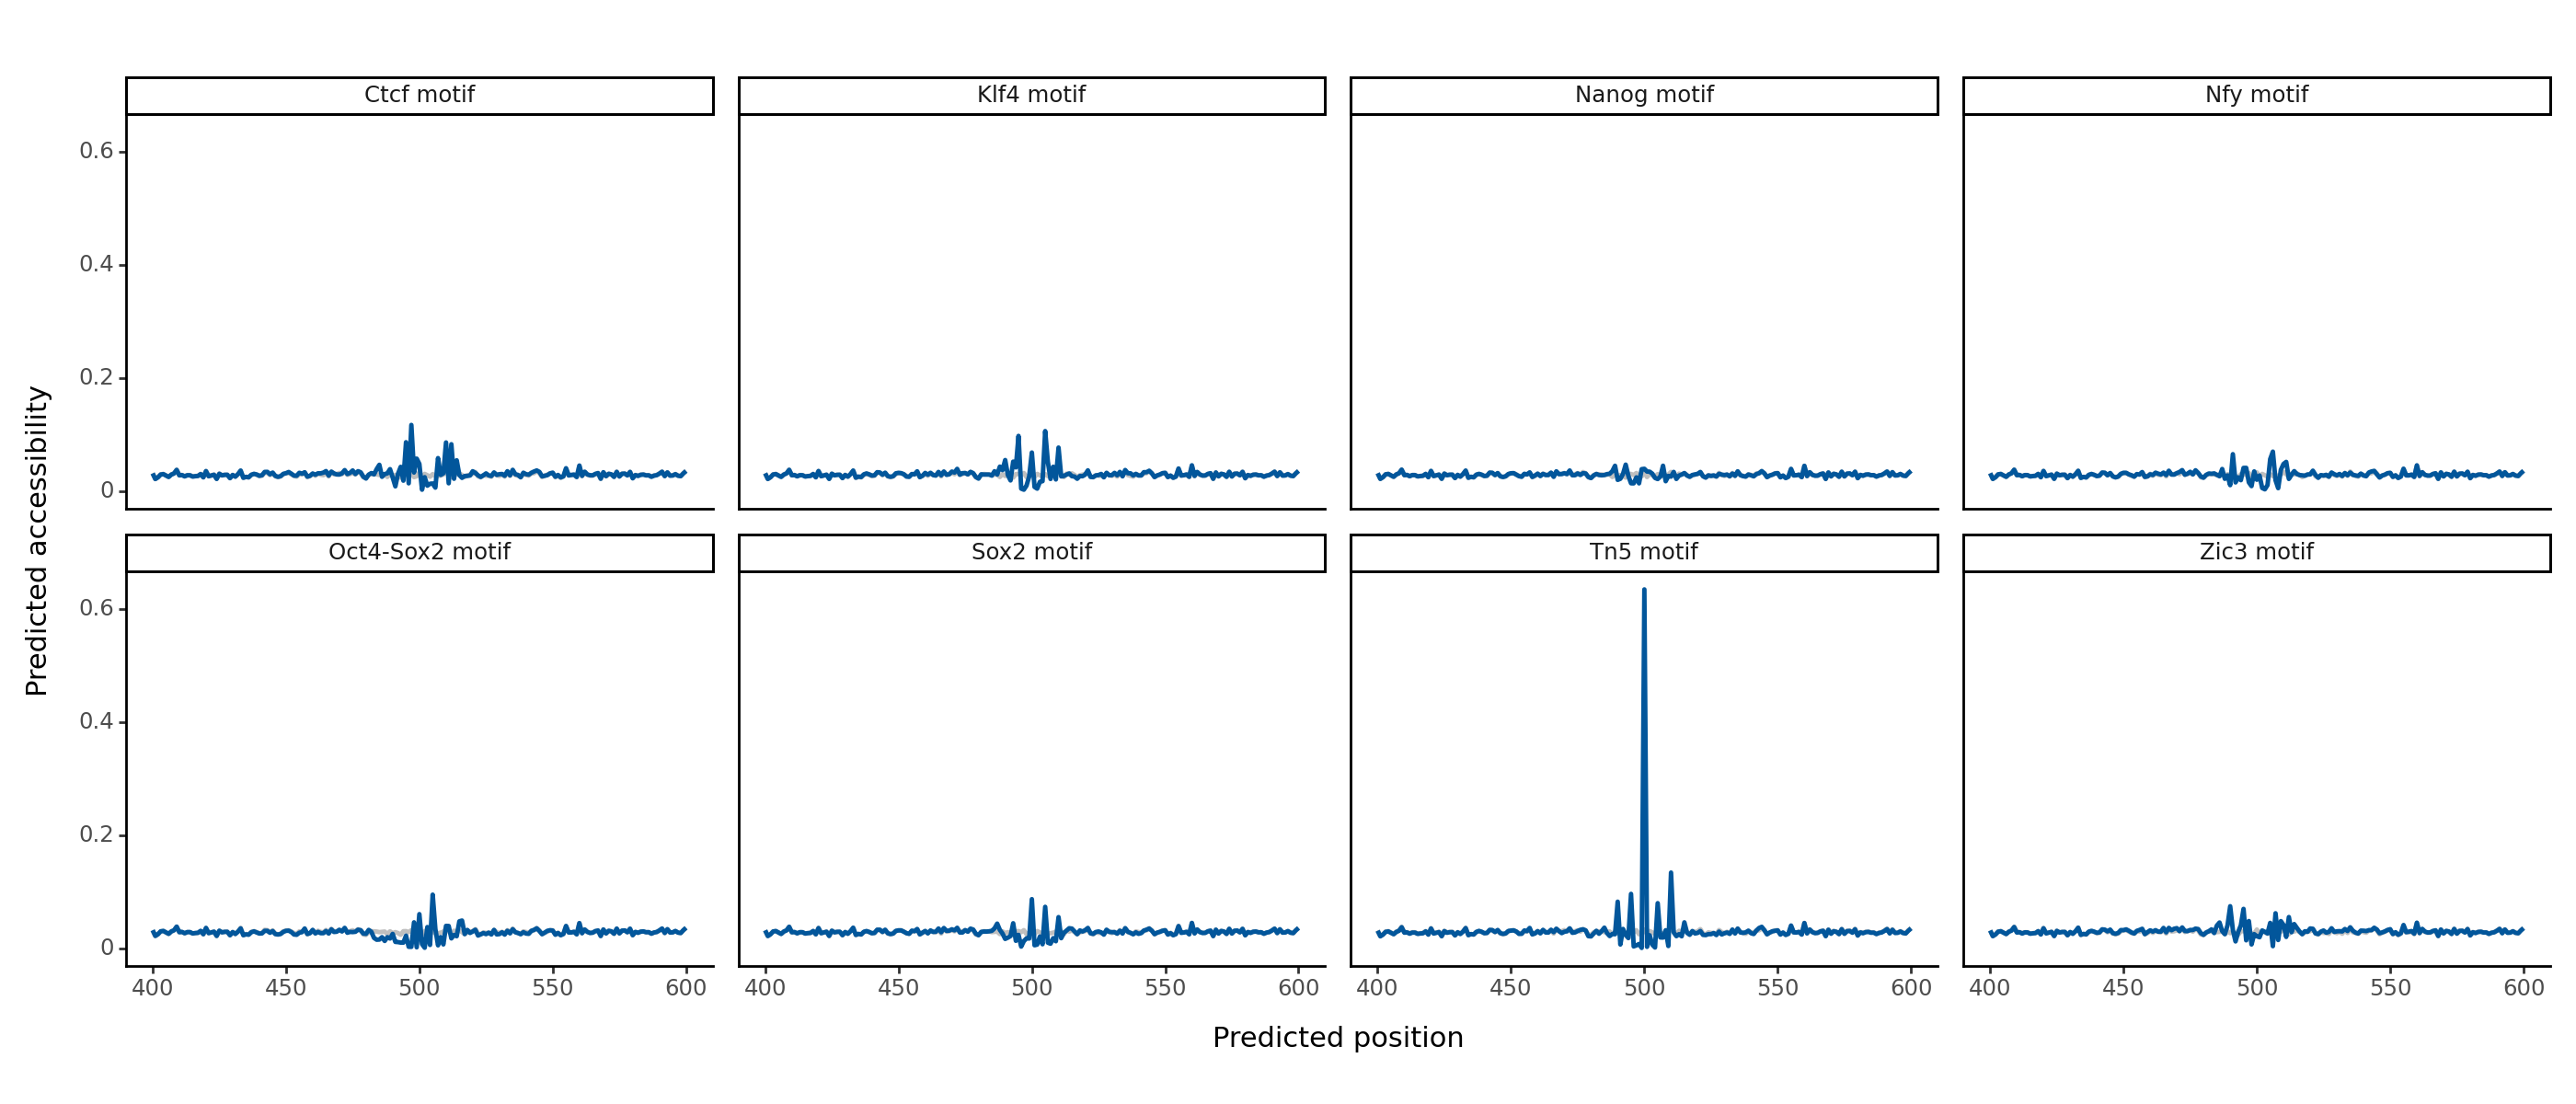

In [23]:
plotnine.options.figure_size = (14, 6)

showcase_injections_plot = (ggplot()+
    geom_line(data = null_preds_df[(null_preds_df['position']>=400) & (null_preds_df['position']<=600)],
              mapping = aes(x = 'position', y = 'pred'), color = 'gray', alpha = .5, size = 1)+
    geom_line(data = injected_preds_df[(injected_preds_df['position']>=400) & (injected_preds_df['position']<=600)],
              mapping = aes(x = 'position', y = 'pred'), color = '#02569b', size = 1)+
    scale_x_continuous(name = 'Predicted position')+
    scale_y_continuous(name = 'Predicted accessibility')+
    facet_wrap('~ motif', scales = 'fixed', nrow = 2)+
    theme_classic())

showcase_injections_plot.save(f'{figure_path}/Tn5_motif_injections.png')
showcase_injections_plot.save(f'{figure_path}/Tn5_motif_injections.pdf')

print(showcase_injections_plot)

All of the motifs show classical Tn5 sequence bias cuts and we can see that they do not contribute to accessibility.

## Train transformation model

In order to correct for sequencing depth variability of a bias model versus a residual ChromBPNet model trained on different ATAC-seq data, a transformation model needs to be added to the end of the frozen bias model. This transformation model is a "simple" 1-layer linear regression that simply addresses a scaling transformation. This differs from ChromBPNet, where they scale the bias model manually using measured sequencing depth differences. However, both approaches accomplish the same thing.

Configure training parameters for the transformation model.

In [24]:
train_dict = {'settings': {'output-prefix': f'models/{trans_prefix}', 
                           'epochs': 200, 
                           'early-stopping-patience': early_stopping_patience, 
                           'batch-size': batch_size, 
                           'learning-rate': 0.04, #Note the very aggressive LR because there are so few parameters. 
                           'learning-rate-plateau-patience': 5, 
                           'solo-model-file': f'models/optimize/{bias_prefix}.model',
                           'input-length': bias_input_length, 
                           'output-length': output_length, 
                           'max-jitter': max_jitter, 
                           'profile-architecture' : {
                                'name' : 'simple', 
                                'types' : ['linear', 'sigmoid']},
                           'counts-architecture' : {
                                'name' : 'simple', 
                                'types' : ['linear', 'sigmoid']}},     
              'train-data': f'input/optimize/{trans_prefix}_train.h5', 
              'val-data': f'input/optimize/{trans_prefix}_val.h5', 
              'heads': [{'num-tasks': 1, 
                         'profile-loss-weight': 1, 
                         'head-name': task, 
                         'counts-loss-weight': bias_dict['counts_loss_weight']} 
                        for task in modeling_design_dict['atac_wt']['tasks']],
              'verbosity': 'WARNING'}
train_json = json.dumps(train_dict, indent=4)
train_json_file = f'json/optimize/trainTransformationModel_{trans_prefix}.json'
with open(train_json_file, 'w') as outfile:
    outfile.write(train_json)

In [25]:
#Set up training and prediction commands
model_train = [f'{python_path} {bpreveal_path}/src/trainTransformationModel.py json/optimize/trainTransformationModel_{trans_prefix}.json']

#Write the script
cmds = gpu_header + model_train 
with open(f'scripts/optimize/bpnet_train_{trans_prefix}.slurm', mode='wt') as slurm:
    slurm.write('\n'.join(cmds))
    slurm.write('\n')
print('sbatch ', f'scripts/optimize/bpnet_train_{trans_prefix}.slurm')

sbatch  scripts/optimize/bpnet_train_atac_wt_trans.slurm


With the transformation model for the ATAC-seq wildtype set, its time to optimize our BPNet and ChromBPNet models.

## Generate training scripts

Here, we will generate training .json configuration files and training scripts for the optimization step.

In [26]:
for model_name,model_info in modeling_design_dict.items():
    for param_name, param_values in opt_dict.items():
        for i,param_value in enumerate(param_values):
    
            #Overwrite parameter in appropriate field
            current_settings_dict = default_dict.copy()
            current_settings_dict[param_name] = param_value
            
            #Assign corresponding input length
            input_length = input_lengths_dict[param_name][i]
            
            #Set up parameter prefix and input length prefix to reference the data and regions to train on.
            param_prefix = model_name + '_' + '_'.join([k + '_' + str(v) for k,v in current_settings_dict.items()])
            print(param_prefix)
            input_length_prefix = model_name + '_' + str(input_length)

            #Set up training parameters for the base model
            train_dict = {'settings': {'output-prefix': f'models/optimize/{param_prefix}', 
                                       'epochs': 200, 
                                       'early-stopping-patience': early_stopping_patience, 
                                       'batch-size': batch_size, 
                                       'learning-rate': learning_rate, 
                                       'learning-rate-plateau-patience': 5, 
                                       'max-jitter': max_jitter, 
                                       'architecture': {'architecture-name': 'bpnet', 
                                                        'input-length': input_length, 
                                                        'output-length': output_length, 
                                                        'model-name': param_prefix, 
                                                        'model-args': '', 
                                                        'filters': current_settings_dict['filters'], 
                                                        'layers': current_settings_dict['n_dil_layers'], 
                                                        'input-filter-width': current_settings_dict['conv1_kernel_size'], 
                                                        'output-filter-width': current_settings_dict['profile_kernel_size']}}, 
                          'train-data': f'input/optimize/{input_length_prefix}_train.h5', 
                          'val-data': f'input/optimize/{input_length_prefix}_val.h5', 
                          'verbosity': 'WARNING'}

            if model_info['tasks'][0]=='atac':
                model_suffix = '_residual.model'
                train_dict['settings']['transformation-model'] = {'transformation-model-file' : f'models/{trans_prefix}.model'}
                train_dict['heads'] = [{'num-tasks': model_info['num-channels'], 
                                     'profile-loss-weight': 1, 
                                     'head-name': task, 
                                     'counts-loss-weight': current_settings_dict['counts_loss_weight'],
                                     'use-bias-counts': False} 
                                    for task in model_info['tasks']]
                train_json = json.dumps(train_dict, indent=4)
                train_json_file = f'json/optimize/trainCombinedModel_{param_prefix}.json'
                with open(train_json_file, 'w') as outfile:
                    outfile.write(train_json)
            else:
                model_suffix = '.model'
                train_dict['heads'] = [{'num-tasks': model_info['num-channels'], 
                                     'profile-loss-weight': 1, 
                                     'head-name': task, 
                                     'counts-loss-weight': current_settings_dict['counts_loss_weight']} 
                                    for task in model_info['tasks']]
                train_json = json.dumps(train_dict, indent=4)
                train_json_file = f'json/optimize/trainSoloModel_{param_prefix}.json'
                with open(train_json_file, 'w') as outfile:
                    outfile.write(train_json)
                
            #Set up prediction parameters
            pred_dict = {'settings': {'genome': genome, 
                                      'output-h5': f'preds/optimize/{param_prefix}_peaks_test.h5', 
                                      'batch-size': batch_size, 
                                      'heads': len(model_info['tasks']), 
                                      'architecture': {'model-file': f'models/optimize/{param_prefix}{model_suffix}', 
                                                       'input-length': input_length, 
                                                       'output-length': output_length}}, 
                         'bed-file': f'bed/bpreveal/optimize/{input_length_prefix}_test.bed', 
                         'verbosity': 'DEBUG'}
            pred_json = json.dumps(pred_dict, indent=4)
            pred_json_file = f'json/optimize/predictPeaks_{param_prefix}.json'
            with open(pred_json_file, 'w') as outfile:
                outfile.write(pred_json)

atac_wt_n_dil_layers_7_conv1_kernel_size_25_profile_kernel_size_25_filters_64_counts_loss_weight_10
atac_wt_n_dil_layers_8_conv1_kernel_size_25_profile_kernel_size_25_filters_64_counts_loss_weight_10
atac_wt_n_dil_layers_9_conv1_kernel_size_25_profile_kernel_size_25_filters_64_counts_loss_weight_10
atac_wt_n_dil_layers_10_conv1_kernel_size_25_profile_kernel_size_25_filters_64_counts_loss_weight_10
atac_wt_n_dil_layers_11_conv1_kernel_size_25_profile_kernel_size_25_filters_64_counts_loss_weight_10
atac_wt_n_dil_layers_9_conv1_kernel_size_7_profile_kernel_size_25_filters_64_counts_loss_weight_10
atac_wt_n_dil_layers_9_conv1_kernel_size_51_profile_kernel_size_25_filters_64_counts_loss_weight_10
atac_wt_n_dil_layers_9_conv1_kernel_size_25_profile_kernel_size_7_filters_64_counts_loss_weight_10
atac_wt_n_dil_layers_9_conv1_kernel_size_25_profile_kernel_size_51_filters_64_counts_loss_weight_10
atac_wt_n_dil_layers_9_conv1_kernel_size_25_profile_kernel_size_25_filters_16_counts_loss_weight_10


Generate .slurm files for each optimization model training and prediction. Print the SLURM commands to queue them (manually enter them, you don't need to automate this, Melanie).

In [27]:
for model_name,model_info in modeling_design_dict.items():
    for param_name, param_values in opt_dict.items():
        for i,param_value in enumerate(param_values):
    
            #Overwrite parameter in appropriate field
            current_settings_dict = default_dict.copy()
            current_settings_dict[param_name] = param_value
            
            #Set up parameter prefix and input length prefix to reference the data and regions to train on.
            param_prefix = model_name + '_' + '_'.join([k + '_' + str(v) for k,v in current_settings_dict.items()])
            
            if model_info['tasks'][0]=='atac':
                train_type = 'trainCombinedModel'
            else: 
                train_type = 'trainSoloModel'
            
            #Set up training and prediction commands
            model_train = [f'{python_path} {bpreveal_path}/src/{train_type}.py json/optimize/{train_type}_{param_prefix}.json']
            model_predict = [f'{python_path} {bpreveal_path}/src/makePredictionsBed.py json/optimize/predictPeaks_{param_prefix}.json']
    
            #Write the script
            cmds = gpu_header + model_train + model_predict
            with open(f'scripts/optimize/bpnet_train_{param_prefix}.slurm', mode='wt') as slurm:
                slurm.write('\n'.join(cmds))
                slurm.write('\n')
            print('sbatch ', f'scripts/optimize/bpnet_train_{param_prefix}.slurm')

sbatch  scripts/optimize/bpnet_train_atac_wt_n_dil_layers_7_conv1_kernel_size_25_profile_kernel_size_25_filters_64_counts_loss_weight_10.slurm
sbatch  scripts/optimize/bpnet_train_atac_wt_n_dil_layers_8_conv1_kernel_size_25_profile_kernel_size_25_filters_64_counts_loss_weight_10.slurm
sbatch  scripts/optimize/bpnet_train_atac_wt_n_dil_layers_9_conv1_kernel_size_25_profile_kernel_size_25_filters_64_counts_loss_weight_10.slurm
sbatch  scripts/optimize/bpnet_train_atac_wt_n_dil_layers_10_conv1_kernel_size_25_profile_kernel_size_25_filters_64_counts_loss_weight_10.slurm
sbatch  scripts/optimize/bpnet_train_atac_wt_n_dil_layers_11_conv1_kernel_size_25_profile_kernel_size_25_filters_64_counts_loss_weight_10.slurm
sbatch  scripts/optimize/bpnet_train_atac_wt_n_dil_layers_9_conv1_kernel_size_7_profile_kernel_size_25_filters_64_counts_loss_weight_10.slurm
sbatch  scripts/optimize/bpnet_train_atac_wt_n_dil_layers_9_conv1_kernel_size_51_profile_kernel_size_25_filters_64_counts_loss_weight_10.slur

# Generate prediction .bw files and assess performance

Here, we will extract .bw coverage from the generated .h5 files and compare them to generated features in order to compute performance metrics

## Generate prediction .bw files


In [28]:
%%script false --no-raise-error
for model_name,model_info in modeling_design_dict.items():
    for param_name, param_values in opt_dict.items():
        for i,param_value in enumerate(param_values):
    
            #Overwrite parameter in appropriate field
            current_settings_dict = default_dict.copy()
            current_settings_dict[param_name] = param_value
            
            #Set up parameter prefix and input length prefix to reference the data and regions to train on.
            param_prefix = model_name + '_' + '_'.join([k + '_' + str(v) for k,v in current_settings_dict.items()])
            
            # Generate prediction .bw files from generated .h5 files
            if type(model_info['cov'])==str:
                    channel_name = 'atac'
                    !{python_path} {bpreveal_path}/src/predictToBigwig.py \
                            --h5 preds/optimize/{param_prefix}_peaks_test.h5 \
                            --bw preds/optimize/{param_prefix}_{channel_name}_{channel_name}_peaks_test.bw \
                            --head-id 0 --task-id 0 \
                            --mode profile --verbose
            else:
                for head_counter, (task, cov) in enumerate(model_info['cov'].items()):
                    for channel_counter, (channel_name, channel) in enumerate(cov.items()):
                        !{python_path} {bpreveal_path}/src/predictToBigwig.py \
                            --h5 preds/optimize/{param_prefix}_peaks_test.h5 \
                            --bw preds/optimize/{param_prefix}_{task}_{channel_name}_peaks_test.bw \
                            --head-id {head_counter} --task-id {channel_counter} \
                            --mode profile --verbose

## Compute performance metrics

Here, we will compute and compare performance metrics on the test set of chromosomes. We will assess the 50th percentile as the key feature of profile metrics as well as the overall total counts performance. 

In [29]:
%%script false --no-raise-error
# %%capture

metrics_df = pd.DataFrame()
for model_name,model_info in modeling_design_dict.items():
    for param_name, param_values in opt_dict.items():
        for i,param_value in enumerate(param_values):
            
            #Overwrite parameter in appropriate field
            current_settings_dict = default_dict.copy()
            current_settings_dict[param_name] = param_value
            
            #Assign corresponding input length
            input_length = input_lengths_dict[param_name][i]
            
            #Set up parameter prefix and input length prefix to reference the data and regions to train on.
            param_prefix = model_name + '_' + '_'.join([k + '_' + str(v) for k,v in current_settings_dict.items()])
            print(param_prefix)
            
            input_length_prefix = model_name + '_' + str(input_length)
            peaks_path = f'bed/bpreveal/optimize/{input_length_prefix}_test.bed'

            # Generate prediction .bw files from generated .h5 files
            if type(model_info['cov'])==str:
                    channel_name = 'atac'
                    reference_path = model_info['cov']
                    preds_path = f'preds/optimize/{param_prefix}_{channel_name}_{channel_name}_peaks_test.bw'

                     #Compute correlations and profile metrics over quantiles
                    metrics_json_file = f'json/optimize/metrics_{param_prefix}_{channel_name}_{channel_name}_peaks_test.json'
                    !{python_path} {bpreveal_path}/src/metrics.py \
                        --reference {reference_path} \
                        --pred {preds_path} \
                        --regions {peaks_path} \
                        --threads 70 --json-output --apply-abs --skip-zeroes | tee {metrics_json_file}
                    with open(metrics_json_file) as f:
                        metrics_dict = json.load(f)
                    
                    # metrics_json = json.dumps(metrics_dict, indent=4)
                    # with open(metrics_json_file, 'w') as outfile:
                    #     outfile.write(metrics_json)

                    df = pd.DataFrame([os.path.basename(metrics_dict['predicted'])]).transpose()
                    df.columns = ['bw']
                    df[['model', 'bw']] = df['bw'].str.split('_n_dil_layers_', n=1, expand=True)
                    df[['n_dil_layers', 'bw']] = df['bw'].str.split('_conv1_kernel_size_', n=1, expand=True)
                    df[['conv1_kernel_size', 'bw']] = df['bw'].str.split('_profile_kernel_size_', n=1, expand=True)
                    df[['profile_kernel_size', 'bw']] = df['bw'].str.split('_filters_', n=1, expand=True)
                    df[['filters', 'bw']] = df['bw'].str.split('_counts_loss_weight_', n=1, expand=True)
                    df[['counts_loss_weight', 'bw']] = df['bw'].str.split(f'_{channel_name}_{channel_name}_', n=1, expand=True)
                    df[['dataset', 'bw']] = df['bw'].str.split(f'.bw', n=1, expand=True)
                    df = df.drop('bw', axis = 1)
                    df[profile_metrics_of_interest] = [np.median(metrics_dict[metric]['quantiles']) for metric in profile_metrics_of_interest]
                    df[counts_metrics_of_interest] = [metrics_dict[metric] for metric in counts_metrics_of_interest]
                    metrics_df = pd.concat([metrics_df, df])
            else:
                 for head_counter, (task, cov) in enumerate(model_info['cov'].items()):
                    for channel_counter, (channel_name, channel) in enumerate(cov.items()):
                        reference_path = f'bw/{os.path.basename(channel)}'
                        preds_path = f'preds/optimize/{param_prefix}_{task}_{channel_name}_peaks_test.bw'

                        #Compute correlations and profile metrics over quantiles
                        metrics_json_file = f'json/optimize/metrics_{param_prefix}_{task}_{channel_name}_peaks_test.json'
                        !{python_path} {bpreveal_path}/src/metrics.py \
                            --reference {reference_path} \
                            --pred {preds_path} \
                            --regions {peaks_path} \
                            --threads 70 --json-output --apply-abs --skip-zeroes | tee {metrics_json_file}
                        with open(metrics_json_file) as f:
                            metrics_dict = json.load(f)

                        df = pd.DataFrame([os.path.basename(metrics_dict['predicted'])]).transpose()
                        df.columns = ['bw']
                        df[['model', 'bw']] = df['bw'].str.split('_n_dil_layers_', n=1, expand=True)
                        df[['n_dil_layers', 'bw']] = df['bw'].str.split('_conv1_kernel_size_', n=1, expand=True)
                        df[['conv1_kernel_size', 'bw']] = df['bw'].str.split('_profile_kernel_size_', n=1, expand=True)
                        df[['profile_kernel_size', 'bw']] = df['bw'].str.split('_filters_', n=1, expand=True)
                        df[['filters', 'bw']] = df['bw'].str.split('_counts_loss_weight_', n=1, expand=True)
                        df[['counts_loss_weight', 'bw']] = df['bw'].str.split(f'_', n=1, expand=True)
                        df[['task', 'bw']] = df['bw'].str.split(f'_peaks_', n=1, expand=True)
                        df[['dataset', 'bw']] = df['bw'].str.split(f'.bw', n=1, expand=True)
                        df = df.drop('bw', axis = 1)
                        df[profile_metrics_of_interest] = [np.median(metrics_dict[metric]['quantiles']) for metric in profile_metrics_of_interest]
                        df[counts_metrics_of_interest] = [metrics_dict[metric] for metric in counts_metrics_of_interest]
                        metrics_df = pd.concat([metrics_df, df])

metrics_df.to_csv('tsv/optimize/optimization_metrics.tsv.gz', sep = '\t', index = False)

In [30]:
metrics_df = pd.read_csv('tsv/optimize/optimization_metrics.tsv.gz', sep = '\t')
print(metrics_df)

           model  n_dil_layers  conv1_kernel_size  profile_kernel_size  \
0    bpnet_osknz             7                 25                   25   
1    bpnet_osknz             7                 25                   25   
2    bpnet_osknz             7                 25                   25   
3    bpnet_osknz             7                 25                   25   
4    bpnet_osknz             7                 25                   25   
..           ...           ...                ...                  ...   
171      atac_wt             9                 25                   25   
172      atac_wt             9                 25                   25   
173      atac_wt             9                 25                   25   
174      atac_wt             9                 25                   25   
175      atac_wt             9                 25                   25   

     filters  counts_loss_weight      task     dataset         mnll       jsd  \
0         64                  

When looking at the generated `tsv/optimize/optimization_metrics.tsv.gz`, we can see a few clear things (this is also a supplementary table):

+ filter length of convolutional and profile output layers perform consistently better across BPNet and ChromBPNet models if they are 7bp/units long
+ filter depth consistently more powerful better across BPNet models if it is 128 filters, ChromBPNet slightly better
+ balancing of for counts and profile loss components (lambda) better across both models when 100
+ number of layers was optimal at 8 layers for BPNet. For ChromBPNet, both 8 layers and 10/11 layers were found to be optimal. Because shallower models have been found (in Melanie's experience both for the Avsec 2021 paper and the Brennan 2023 paper, as well as exploratory investigations) to contain more concise sequence grammar representations (though they often perform ever so slightly worse, though not by any meaningful level worse) that more accurately reflect experimental follow-up experiments (in the case of Brennan 2023). Given this, we will make the decision to keep both BPNet and ChromBPNet models at 8 layers.

Because BPNet and ChromBPNet perform well with the same architecture, our receptive field will be the same, making the exact boundaries of the model's vision of each sequence identical. This will also be optimal in terms of extract interpretations, since our models will be operating over the same architectural assumptions. 

# Train, predict, and SHAP final model in 3 folds

Here, we will take the training configuration and queue training, prediction and SHAP for the final multi-task binding models. We will train in 3 folds of train/test/val chromosome combinations (randomly selected) to ensure that the chromosome allocation is the reason the model performs well. 

In [31]:
train_settings_dict = {
    'n_dil_layers' : 8,
    'conv1_kernel_size' : 7,
    'profile_kernel_size' : 7,
    'filters' : 128,
    'counts_loss_weight' : 100
}

input_length = !{python_path} {bpreveal_path}/src/lengthCalc.py \
        --output-len {output_length} \
        --n-dil-layers {train_settings_dict['n_dil_layers']} \
        --conv1-kernel-size {train_settings_dict['conv1_kernel_size']} \
        --profile-kernel-size {train_settings_dict['profile_kernel_size']}
input_length = int(input_length[0])
input_length

2032

## Modify `modeling_cov_dict` 

Now, we want to train the concentration-dependent ATAC-seq models on the optimized ATAC-seq architecture. To do this, we will add the extra models desired to the `modeling_design_dict` and the `modeling_cov_dict` to ensure that all of the models are being trained properly.

In [32]:
for timepoint in concentration_atac_timepoints:
    modeling_design_dict[f'atac_{timepoint}h'] = {
            'tasks': ['atac'],
            'cov': f'bw/GSE174774_mesc_atac_{timepoint}h_combined.bw',
            'num-channels': 1
    }

In [33]:
#Prepare .bw configurations. Remember, order matters here.
modeling_cov_dict = {}
for k,v in modeling_design_dict.items():
    bw_dict = {}
    if type(v['cov'])==str:
        bw_dict['prepare_bed_inputs'] = [{'bigwig-names': [v['cov']], 'max-quantile': 1, 'min-counts': 1}]
        bw_dict['prepare_train_inputs'] = [{'bigwig-files': [v['cov']], 'revcomp-task-order': 'auto'}]
    else:
        bw_dict['prepare_bed_inputs'] = [{'bigwig-names': list(v2.values()), 'max-quantile': 1, 'min-counts': 1} for v2 in v['cov'].values()]
        bw_dict['prepare_train_inputs'] = [{'bigwig-files': list(v2.values()), 'revcomp-task-order': 'auto'} for v2 in v['cov'].values()]
    modeling_cov_dict[k] = bw_dict
modeling_cov_dict.keys()

dict_keys(['atac_wt', 'atac_0h', 'atac_3h', 'atac_6h', 'atac_9h', 'atac_12h', 'atac_15h'])

## Prepare 3-fold region datasets

In [34]:
chromosome_folds_dict = {
    'fold1': {'train' : train_chroms,
              'val' : val_chroms,
              'test' : test_chroms},
    'fold2': {'train' : ['chr1', 'chr2', 'chr6', 'chr7', 'chr8', 'chr9', 'chr11', 'chr12', 
                       'chr13', 'chr14', 'chr15','chr17', 'chr18', 'chr19'],
              'val' : ['chr3', 'chr5', 'chr16'],
              'test' : ['chr4', 'chr10', 'chrX']},
    'fold3': {'train' : ['chr2', 'chr3', 'chr6', 'chr8','chr9', 'chr10', 'chr11', 'chr12', 
                       'chr15', 'chr16','chr17', 'chr18', 'chr19', 'chrX'],
              'val' : ['chr1', 'chr7', 'chr13'],
              'test' : ['chr4', 'chr5', 'chr14']}
}

Prepare .bed files in order to train and allocate data and the input files as .h5 files.

In [35]:
%%script false --no-raise-error

#Loop through different input_lengths based on the different model requirements to generate data.
for model_name,model_bws in modeling_cov_dict.items():
    for fold_name,fold_chroms in chromosome_folds_dict.items():
        fold_prefix = model_name + '_' + str(fold_name)
    
        #Consolidate into a .json-readable dictionary
        prepare_bed_regions_dict = {'heads': model_bws['prepare_bed_inputs'],
                                    'splits': {"test-chroms": fold_chroms['test'], 
                                               "val-chroms": fold_chroms['val'],
                                               "train-chroms": fold_chroms['train'],
                                               "regions": list(region_dict.values())},
                                    'genome': f'{genome}',
                                    'write-counts-to': f'bed/bpreveal/{fold_prefix}_all.stats',
                                    'output-length': output_length,
                                    'input-length': input_length,
                                    'max-jitter': max_jitter,
                                    'output-prefix': f'bed/bpreveal/{fold_prefix}',
                                    'resize-mode': 'center',
                                    'remove-overlaps': False,
                                    'verbosity': 'INFO'} #Switch this to DEBUG if you are missing regions
    
        #Write that json.
        prepare_bed_regions_json = json.dumps(prepare_bed_regions_dict, indent=4)
        bed_json_file = f'json/prepareBedPeaks_{fold_prefix}.json'
        with open(bed_json_file, 'w') as outfile:
            outfile.write(prepare_bed_regions_json)
        !{python_path} {bpreveal_path}/src/prepareBed.py {bed_json_file}

        # Prepare input training data
        prepare_input_train_dict = {'genome': genome, 
                            'input-length': input_length, 
                            'output-length': output_length, 
                            'max-jitter': max_jitter, 
                            'regions': f'bed/bpreveal/{fold_prefix}_train.bed', 
                            'output-h5': f'input/{fold_prefix}_train.h5', 
                            'heads': model_bws['prepare_train_inputs'], 
                            'reverse-complement': reverse_complement,
                            'verbosity': 'DEBUG'} 
        prepare_input_train_json = json.dumps(prepare_input_train_dict, indent=4)
        train_json_file = f'json/prepareInputTrain_{fold_prefix}.json'        
        with open(train_json_file, 'w') as outfile:
            outfile.write(prepare_input_train_json)
        !{python_path} {bpreveal_path}/src/prepareTrainingData.py {train_json_file}
            
        # Prepare validation training data
        prepare_input_valid_dict = {'genome': genome, 
                    'input-length': input_length, 
                    'output-length': output_length, 
                    'max-jitter': max_jitter, 
                    'regions': f'bed/bpreveal/{fold_prefix}_val.bed', 
                    'output-h5': f'input/{fold_prefix}_val.h5', 
                    'heads': model_bws['prepare_train_inputs'], 
                    'reverse-complement': reverse_complement,
                    'verbosity': 'DEBUG'} 
        prepare_input_valid_json = json.dumps(prepare_input_valid_dict, indent=4)
        valid_json_file = f'json/prepareInputValid_{fold_prefix}.json'        
        with open(valid_json_file, 'w') as outfile:
            outfile.write(prepare_input_valid_json)
        !{python_path} {bpreveal_path}/src/prepareTrainingData.py {valid_json_file}

## Train adjacent transformation models

### Prepare accessible regions for transformation model

As above, transformation models need to be added for the sequencing depths of each of the ATAC-seq samples across the Oct4-depletion concentrations.

In [36]:
%%script false --no-raise-error

for timepoint in concentration_atac_timepoints:
    trans_prefix = f'atac_{timepoint}h_trans'
    
    #Consolidate into a .json-readable dictionary
    prepare_bed_regions_dict = {'heads': modeling_cov_dict[f'atac_{timepoint}h']['prepare_bed_inputs'],
                                'splits': {"test-chroms": test_chroms, 
                                           "val-chroms": val_chroms,
                                           "train-chroms": train_chroms,
                                           "regions": list(region_dict.values())},
                                'genome': f'{genome}',
                                'write-counts-to': f'bed/bpreveal/optimize/{trans_prefix}_all.stats',
                                'output-length': output_length,
                                'input-length': bias_input_length,
                                'max-jitter': max_jitter,
                                'output-prefix': f'bed/bpreveal/optimize/{trans_prefix}',
                                'resize-mode': 'center',
                                'remove-overlaps': False,
                                'verbosity': 'INFO'} #Switch this to DEBUG if you are missing regions
    
    #Write that json.
    prepare_bed_regions_json = json.dumps(prepare_bed_regions_dict, indent=4)
    
    # Writing to sample.json
    bed_json_file = f'json/optimize/prepareBedPeaks_{trans_prefix}.json'
    with open(bed_json_file, 'w') as outfile:
        outfile.write(prepare_bed_regions_json)
    
    # Run the code to prepare peaks.
    !{python_path} {bpreveal_path}/src/prepareBed.py {bed_json_file}
    
    # Prepare input training data
    prepare_input_train_dict = {'genome': genome, 
                        'input-length': bias_input_length, 
                        'output-length': output_length, 
                        'max-jitter': max_jitter, 
                        'regions': f'bed/bpreveal/optimize/{trans_prefix}_train.bed', 
                        'output-h5': f'input/optimize/{trans_prefix}_train.h5', 
                        'heads': modeling_cov_dict[f'atac_{timepoint}h']['prepare_train_inputs'], 
                        'reverse-complement': reverse_complement,
                        'verbosity': 'DEBUG'} 
    prepare_input_train_json = json.dumps(prepare_input_train_dict, indent=4)
    train_json_file = f'json/optimize/prepareInputTrain_{trans_prefix}.json'        
    with open(train_json_file, 'w') as outfile:
        outfile.write(prepare_input_train_json)
    !{python_path} {bpreveal_path}/src/prepareTrainingData.py {train_json_file}
        
    # Prepare validation training data
    prepare_input_valid_dict = {'genome': genome, 
                'input-length': bias_input_length, 
                'output-length': output_length, 
                'max-jitter': max_jitter, 
                'regions': f'bed/bpreveal/optimize/{trans_prefix}_val.bed', 
                'output-h5': f'input/optimize/{trans_prefix}_val.h5', 
                'heads': modeling_cov_dict[f'atac_{timepoint}h']['prepare_train_inputs'], 
                'reverse-complement': reverse_complement,
                'verbosity': 'DEBUG'} 
    prepare_input_valid_json = json.dumps(prepare_input_valid_dict, indent=4)
    valid_json_file = f'json/optimize/prepareInputValid_{trans_prefix}.json'        
    with open(valid_json_file, 'w') as outfile:
        outfile.write(prepare_input_valid_json)
    !{python_path} {bpreveal_path}/src/prepareTrainingData.py {valid_json_file}

### Train all additional transformation models

In [37]:
for timepoint in concentration_atac_timepoints:
    trans_prefix = f'atac_{timepoint}h_trans'
    train_dict = {'settings': {'output-prefix': f'models/{trans_prefix}', 
                               'epochs': 200, 
                               'early-stopping-patience': early_stopping_patience, 
                               'batch-size': batch_size, 
                               'learning-rate': 0.04, #Note the very aggressive LR because there are so few parameters. 
                               'learning-rate-plateau-patience': 5, 
                               'solo-model-file': f'models/optimize/{bias_prefix}.model',
                               'input-length': bias_input_length, 
                               'output-length': output_length, 
                               'max-jitter': max_jitter, 
                               'profile-architecture' : {
                                    'name' : 'simple', 
                                    'types' : ['linear', 'sigmoid']},
                               'counts-architecture' : {
                                    'name' : 'simple', 
                                    'types' : ['linear', 'sigmoid']}},     
                  'train-data': f'input/optimize/{trans_prefix}_train.h5', 
                  'val-data': f'input/optimize/{trans_prefix}_val.h5', 
                  'heads': [{'num-tasks': 1, 
                             'profile-loss-weight': 1, 
                             'head-name': task, 
                             'counts-loss-weight': bias_dict['counts_loss_weight']} 
                            for task in modeling_design_dict[f'atac_{timepoint}h']['tasks']],
                  'verbosity': 'WARNING'}
    train_json = json.dumps(train_dict, indent=4)
    train_json_file = f'json/optimize/trainTransformationModel_{trans_prefix}.json'
    with open(train_json_file, 'w') as outfile:
        outfile.write(train_json)

    #Set up training and prediction commands
    model_train = [f'{python_path} {bpreveal_path}/src/trainTransformationModel.py json/optimize/trainTransformationModel_{trans_prefix}.json']
    
    #Write the script
    cmds = gpu_header + model_train 
    with open(f'scripts/optimize/bpnet_train_{trans_prefix}.slurm', mode='wt') as slurm:
        slurm.write('\n'.join(cmds))
        slurm.write('\n')
    print('sbatch ', f'scripts/optimize/bpnet_train_{trans_prefix}.slurm')

sbatch  scripts/optimize/bpnet_train_atac_0h_trans.slurm
sbatch  scripts/optimize/bpnet_train_atac_3h_trans.slurm
sbatch  scripts/optimize/bpnet_train_atac_6h_trans.slurm
sbatch  scripts/optimize/bpnet_train_atac_9h_trans.slurm
sbatch  scripts/optimize/bpnet_train_atac_12h_trans.slurm
sbatch  scripts/optimize/bpnet_train_atac_15h_trans.slurm


## Generate training scripts

Here, we will generate training .json configuration files and training scripts for the final training.

In [38]:
for model_name,model_info in modeling_design_dict.items():
    for fold_name,fold_chroms in chromosome_folds_dict.items():
        fold_prefix = model_name + '_' + str(fold_name)

        #Set up training parameters for the base model
        train_dict = {'settings': {'output-prefix': f'models/{fold_prefix}', 
                                   'epochs': 200, 
                                   'early-stopping-patience': early_stopping_patience, 
                                   'batch-size': batch_size, 
                                   'learning-rate': learning_rate, 
                                   'learning-rate-plateau-patience': 5, 
                                   'max-jitter': max_jitter, 
                                   'architecture': {'architecture-name': 'bpnet', 
                                                    'input-length': input_length, 
                                                    'output-length': output_length, 
                                                    'model-name': fold_prefix, 
                                                    'model-args': '', 
                                                    'filters': train_settings_dict['filters'], 
                                                    'layers': train_settings_dict['n_dil_layers'], 
                                                    'input-filter-width': train_settings_dict['conv1_kernel_size'], 
                                                    'output-filter-width': train_settings_dict['profile_kernel_size']}}, 
                      'train-data': f'input/{fold_prefix}_train.h5', 
                      'val-data': f'input/{fold_prefix}_val.h5', 
                      'verbosity': 'WARNING'}

        if model_info['tasks'][0]=='atac':
            model_suffix = ['_combined.model', '_residual.model']
            train_type = 'trainCombinedModel'
            train_dict['settings']['transformation-model'] = {'transformation-model-file' : f'models/{model_name}_trans.model'}
            train_dict['heads'] = [{'num-tasks': model_info['num-channels'], 
                                 'profile-loss-weight': 1, 
                                 'head-name': task, 
                                 'counts-loss-weight': train_settings_dict['counts_loss_weight'],
                                 'use-bias-counts': False} 
                                for task in model_info['tasks']]
            train_json = json.dumps(train_dict, indent=4)
            train_json_file = f'json/trainCombinedModel_{fold_prefix}.json'
            with open(train_json_file, 'w') as outfile:
                outfile.write(train_json)
        else:
            model_suffix = ['.model']
            train_type = 'trainSoloModel'
            train_dict['heads'] = [{'num-tasks': model_info['num-channels'], 
                                 'profile-loss-weight': 1, 
                                 'head-name': task, 
                                 'counts-loss-weight': train_settings_dict['counts_loss_weight']} 
                                for task in model_info['tasks']]
            train_json = json.dumps(train_dict, indent=4)
            train_json_file = f'json/trainSoloModel_{fold_prefix}.json'
            with open(train_json_file, 'w') as outfile:
                outfile.write(train_json)
            
        #Set up prediction parameters
        model_predict = []
        for ms in model_suffix:
            ms_short = ms.replace('.model', '')
            pred_dict = {'settings': {'genome': genome, 
                                      'output-h5': f'preds/{fold_prefix}{ms_short}_peaks_all.h5', 
                                      'batch-size': batch_size, 
                                      'heads': len(model_info['tasks']), 
                                      'architecture': {'model-file': f'models/{fold_prefix}{ms}', 
                                                       'input-length': input_length, 
                                                       'output-length': output_length}}, 
                         'bed-file': f'bed/bpreveal/{fold_prefix}_all.bed', 
                         'verbosity': 'DEBUG'}
            pred_json = json.dumps(pred_dict, indent=4)
            pred_json_file = f'json/predictPeaks_{fold_prefix}{ms_short}.json'
            with open(pred_json_file, 'w') as outfile:
                outfile.write(pred_json)
            model_predict.append(f'{python_path} {bpreveal_path}/src/makePredictionsBed.py json/predictPeaks_{fold_prefix}{ms_short}.json')
        
        #Set up training and prediction commands
        model_train = [f'{python_path} {bpreveal_path}/src/{train_type}.py json/{train_type}_{fold_prefix}.json']

        #Write the script
        # cmds = gpu_header + model_predict
        cmds = gpu_header + model_train + model_predict
        with open(f'scripts/bpnet_train_{fold_prefix}.slurm', mode='wt') as slurm:
            slurm.write('\n'.join(cmds))
            slurm.write('\n')
        print('sbatch ', f'scripts/bpnet_train_{fold_prefix}.slurm')

sbatch  scripts/bpnet_train_atac_wt_fold1.slurm
sbatch  scripts/bpnet_train_atac_wt_fold2.slurm
sbatch  scripts/bpnet_train_atac_wt_fold3.slurm
sbatch  scripts/bpnet_train_atac_0h_fold1.slurm
sbatch  scripts/bpnet_train_atac_0h_fold2.slurm
sbatch  scripts/bpnet_train_atac_0h_fold3.slurm
sbatch  scripts/bpnet_train_atac_3h_fold1.slurm
sbatch  scripts/bpnet_train_atac_3h_fold2.slurm
sbatch  scripts/bpnet_train_atac_3h_fold3.slurm
sbatch  scripts/bpnet_train_atac_6h_fold1.slurm
sbatch  scripts/bpnet_train_atac_6h_fold2.slurm
sbatch  scripts/bpnet_train_atac_6h_fold3.slurm
sbatch  scripts/bpnet_train_atac_9h_fold1.slurm
sbatch  scripts/bpnet_train_atac_9h_fold2.slurm
sbatch  scripts/bpnet_train_atac_9h_fold3.slurm
sbatch  scripts/bpnet_train_atac_12h_fold1.slurm
sbatch  scripts/bpnet_train_atac_12h_fold2.slurm
sbatch  scripts/bpnet_train_atac_12h_fold3.slurm
sbatch  scripts/bpnet_train_atac_15h_fold1.slurm
sbatch  scripts/bpnet_train_atac_15h_fold2.slurm
sbatch  scripts/bpnet_train_atac_15

## Generate prediction .bw files and assess performance

Here, we will extract .bw coverage from the generated .h5 files and compare them to generated features in order to compute performance metrics

In [39]:
%%script false --no-raise-error
for model_name,model_info in modeling_design_dict.items():
    for fold_name,fold_chroms in chromosome_folds_dict.items():
        fold_prefix = model_name + '_' + str(fold_name)
            
        # Generate prediction .bw files from generated .h5 files
        if type(model_info['cov'])==str:
            channel_name = 'atac'
            model_suffix = ['_combined.model', '_residual.model']

            for ms in model_suffix:
                ms_short = ms.replace('.model', '')   
                !{python_path} {bpreveal_path}/src/predictToBigwig.py \
                        --h5 preds/{fold_prefix}{ms_short}_peaks_all.h5 \
                        --bw preds/{fold_prefix}{ms_short}_{channel_name}_{channel_name}_peaks_all.bw \
                        --head-id 0 --task-id 0 \
                        --mode profile --verbose
        else:
            for head_counter, (task, cov) in enumerate(model_info['cov'].items()):
                for channel_counter, (channel_name, channel) in enumerate(cov.items()):
                    !{python_path} {bpreveal_path}/src/predictToBigwig.py \
                        --h5 preds/{fold_prefix}_peaks_all.h5 \
                        --bw preds/{fold_prefix}_{task}_{channel_name}_peaks_all.bw \
                        --head-id {head_counter} --task-id {channel_counter} \
                        --mode profile --verbose

## Compute performance metrics

Here, we will compute and compare performance metrics on the test set of chromosomes. We will assess the 50th percentile as the key feature of profile metrics as well as the overall total counts performance. 

In [40]:
%%script false --no-raise-error
# %%capture

metrics_df = pd.DataFrame()
for model_name,model_info in modeling_design_dict.items():
    for fold_name,fold_chroms in chromosome_folds_dict.items():
        fold_prefix = model_name + '_' + str(fold_name)
        for dataset in ['test','val','train']:
        
            peaks_path = f'bed/bpreveal/{fold_prefix}_{dataset}.bed'
    
            # Generate prediction .bw files from generated .h5 files
            if type(model_info['cov'])==str:
                channel_name = 'atac'
                reference_path = model_info['cov']
                preds_path = f'preds/{fold_prefix}_{channel_name}_{channel_name}_peaks_all.bw'

                 #Compute correlations and profile metrics over quantiles
                metrics_json_file = f'json/metrics_{fold_prefix}_{channel_name}_{channel_name}_peaks_{dataset}.json'
                !{python_path} {bpreveal_path}/src/metrics.py \
                    --reference {reference_path} \
                    --pred {preds_path} \
                    --regions {peaks_path} \
                    --threads 70 --json-output --apply-abs --skip-zeroes | tee {metrics_json_file}
                with open(metrics_json_file) as f:
                    metrics_dict = json.load(f)

                df = pd.DataFrame([os.path.basename(metrics_dict['predicted'])]).transpose()
                df.columns = ['bw']
                df[['model', 'bw']] = df['bw'].str.split('_fold', n=1, expand=True)
                df[['fold', 'bw']] = df['bw'].str.split('_', n=1, expand=True)
                df[['task', 'bw']] = df['bw'].str.split('_peaks_', n=1, expand=True)
                df[['peaks', 'bw']] = df['bw'].str.split(f'.bw', n=1, expand=True)
                df['dataset'] = dataset
                df = df.drop('bw', axis = 1)
                df[profile_metrics_of_interest] = [np.median(metrics_dict[metric]['quantiles']) for metric in profile_metrics_of_interest]
                df[counts_metrics_of_interest] = [metrics_dict[metric] for metric in counts_metrics_of_interest]
                metrics_df = pd.concat([metrics_df, df])
            else:
                for head_counter, (task, cov) in enumerate(model_info['cov'].items()):
                    for channel_counter, (channel_name, channel) in enumerate(cov.items()):
                        reference_path = f'bw/{os.path.basename(channel)}'
                        preds_path = f'preds/{fold_prefix}_{task}_{channel_name}_peaks_all.bw'
                    
                        #Compute correlations and profile metrics over quantiles
                        metrics_json_file = f'json/metrics_{fold_prefix}_{task}_{channel_name}_peaks_{dataset}.json'
                        !{python_path} {bpreveal_path}/src/metrics.py \
                            --reference {reference_path} \
                            --pred {preds_path} \
                            --regions {peaks_path} \
                            --threads 70 --json-output --apply-abs --skip-zeroes | tee {metrics_json_file}
                        with open(metrics_json_file) as f:
                            metrics_dict = json.load(f)
                    
                        df = pd.DataFrame([os.path.basename(metrics_dict['predicted'])]).transpose()
                        df.columns = ['bw']
                        df[['model', 'bw']] = df['bw'].str.split('_fold', n=1, expand=True)
                        df[['fold', 'bw']] = df['bw'].str.split('_', n=1, expand=True)
                        df[['task', 'bw']] = df['bw'].str.split('_peaks_', n=1, expand=True)
                        df[['peaks', 'bw']] = df['bw'].str.split(f'.bw', n=1, expand=True)
                        df['dataset'] = dataset
                        df = df.drop('bw', axis = 1)
                        df[profile_metrics_of_interest] = [np.median(metrics_dict[metric]['quantiles']) for metric in profile_metrics_of_interest]
                        df[counts_metrics_of_interest] = [metrics_dict[metric] for metric in counts_metrics_of_interest]
                        metrics_df = pd.concat([metrics_df, df])

metrics_df.to_csv('tsv/performance_metrics.tsv.gz', sep = '\t', index = False)

In [41]:
metrics_df = pd.read_csv('tsv/performance_metrics.tsv.gz', sep = '\t')
print(metrics_df)

           model  fold       task peaks dataset         mnll       jsd  \
0    bpnet_osknz     1   oct4_pos   all    test  -368.032026  0.681369   
1    bpnet_osknz     1   oct4_neg   all    test  -368.875138  0.682232   
2    bpnet_osknz     1   sox2_pos   all    test  -215.591828  0.746592   
3    bpnet_osknz     1   sox2_neg   all    test  -215.570117  0.746974   
4    bpnet_osknz     1   klf4_pos   all    test  -409.525255  0.655120   
..           ...   ...        ...   ...     ...          ...       ...   
148     atac_15h     2  atac_atac   all     val -2912.333824  0.119966   
149     atac_15h     2  atac_atac   all   train -2793.052565  0.106032   
150     atac_15h     3  atac_atac   all    test -2937.178788  0.121737   
151     atac_15h     3  atac_atac   all     val -2912.660177  0.121742   
152     atac_15h     3  atac_atac   all   train -2824.884430  0.109559   

     counts-pearson  counts-spearman  
0          0.189074         0.607753  
1          0.168863         0.610

# Calculate SHAP scores for all models

## Generate SHAP scores for key models

In [42]:
for model_name,model_info in modeling_design_dict.items():
    for fold_name,fold_chroms in chromosome_folds_dict.items():
        fold_prefix = model_name + '_' + str(fold_name)

        #Set up SHAP parameters for each task.
        shap_template_dict = {
            'genome': genome,
            'bed-file': f'bed/bpreveal/{fold_prefix}_all.bed', 
            'input-length': input_length,
            'output-length': output_length,
            'num-shuffles': 20,
            'verbosity': 'DEBUG'
        }

        #For ATAC vs CHIP-nexus, set up SHAP parameters
        if model_info['tasks'][0]=='atac':
            task = 'atac'
            model_suffix = '_residual.model'
            shap_dict = shap_template_dict.copy()
            shap_dict['model-file'] = f'models/{fold_prefix}{model_suffix}'
            shap_dict['heads'] = 1
            shap_dict['head-id'] = 0
            shap_dict['profile-task-ids'] = [0]
            shap_dict['profile-h5'] = f'shap/{fold_prefix}_{task}_profile.h5'
            shap_dict['counts-h5'] = f'shap/{fold_prefix}_{task}_counts.h5'
            shap_json = json.dumps(shap_dict, indent=4)
            shap_json_file = f'json/shapFlat_{fold_prefix}_{task}.json'
            with open(shap_json_file, 'w') as outfile:
                outfile.write(shap_json)     
    
            #Set up the SHAP commands
            model_shap = [f'{python_path} {bpreveal_path}/src/interpretFlat.py json/shapFlat_{fold_prefix}_{task}.json']
            cmds = gpu_header + model_shap
            with open(f'scripts/bpnet_shap_{fold_prefix}_{task}.slurm', mode='wt') as slurm:
                slurm.write('\n'.join(cmds))
                slurm.write('\n')
            print('sbatch ', f'scripts/bpnet_shap_{fold_prefix}_{task}.slurm')
            
        else:
            model_suffix = '.model'
            shap_dict = shap_template_dict.copy()
            shap_dict['model-file'] = f'models/{fold_prefix}{model_suffix}'
            for head_counter, (task, cov) in enumerate(model_info['cov'].items()):
                shap_dict['heads'] = len(model_info['tasks'])
                shap_dict['head-id'] = head_counter
                shap_dict['profile-task-ids'] = [0,1]
                shap_dict['profile-h5'] = f'shap/{fold_prefix}_{task}_profile.h5'
                shap_dict['counts-h5'] = f'shap/{fold_prefix}_{task}_counts.h5'
                shap_json = json.dumps(shap_dict, indent=4)
                shap_json_file = f'json/shapFlat_{fold_prefix}_{task}.json'
                with open(shap_json_file, 'w') as outfile:
                    outfile.write(shap_json)     
        
                #Set up the SHAP commands
                model_shap = [f'{python_path} {bpreveal_path}/src/interpretFlat.py json/shapFlat_{fold_prefix}_{task}.json']
                cmds = gpu_header + model_shap
                with open(f'scripts/bpnet_shap_{fold_prefix}_{task}.slurm', mode='wt') as slurm:
                    slurm.write('\n'.join(cmds))
                    slurm.write('\n')
                print('sbatch ', f'scripts/bpnet_shap_{fold_prefix}_{task}.slurm')        

sbatch  scripts/bpnet_shap_atac_wt_fold1_atac.slurm
sbatch  scripts/bpnet_shap_atac_wt_fold2_atac.slurm
sbatch  scripts/bpnet_shap_atac_wt_fold3_atac.slurm
sbatch  scripts/bpnet_shap_atac_0h_fold1_atac.slurm
sbatch  scripts/bpnet_shap_atac_0h_fold2_atac.slurm
sbatch  scripts/bpnet_shap_atac_0h_fold3_atac.slurm
sbatch  scripts/bpnet_shap_atac_3h_fold1_atac.slurm
sbatch  scripts/bpnet_shap_atac_3h_fold2_atac.slurm
sbatch  scripts/bpnet_shap_atac_3h_fold3_atac.slurm
sbatch  scripts/bpnet_shap_atac_6h_fold1_atac.slurm
sbatch  scripts/bpnet_shap_atac_6h_fold2_atac.slurm
sbatch  scripts/bpnet_shap_atac_6h_fold3_atac.slurm
sbatch  scripts/bpnet_shap_atac_9h_fold1_atac.slurm
sbatch  scripts/bpnet_shap_atac_9h_fold2_atac.slurm
sbatch  scripts/bpnet_shap_atac_9h_fold3_atac.slurm
sbatch  scripts/bpnet_shap_atac_12h_fold1_atac.slurm
sbatch  scripts/bpnet_shap_atac_12h_fold2_atac.slurm
sbatch  scripts/bpnet_shap_atac_12h_fold3_atac.slurm
sbatch  scripts/bpnet_shap_atac_15h_fold1_atac.slurm
sbatch  

## Generate SHAP scores for bias model

In [43]:
#Set up SHAP parameters for each task.
task = 'atac'
shap_template_dict = {
    'genome': genome,
    'bed-file': f'bed/bpreveal/optimize/atac_wt_trans_all.bed', 
    'input-length': bias_input_length,
    'output-length': output_length,
    'num-shuffles': 20,
    'model-file' : f'models/optimize/{bias_prefix}.model',
    'heads' : 1,
    'head-id' : 0,
    'profile-task-ids' : [0],
    'profile-h5' : f'shap/{bias_prefix}_{task}_profile.h5',
    'counts-h5' : f'shap/{bias_prefix}_{task}_counts.h5',
    'verbosity': 'DEBUG'
}
shap_json = json.dumps(shap_template_dict, indent=4)
shap_json_file = f'json/shapFlat_{bias_prefix}_{task}.json'
with open(shap_json_file, 'w') as outfile:
    outfile.write(shap_json)     

#Set up the SHAP commands
model_shap = [f'{python_path} {bpreveal_path}/src/interpretFlat.py json/shapFlat_{bias_prefix}_{task}.json']
cmds = gpu_header + model_shap
with open(f'scripts/bpnet_shap_{bias_prefix}_{task}.slurm', mode='wt') as slurm:
    slurm.write('\n'.join(cmds))
    slurm.write('\n')
print('sbatch ', f'scripts/bpnet_shap_{bias_prefix}_{task}.slurm')

sbatch  scripts/bpnet_shap_atac_bias_atac.slurm


## Convert SHAP .h5 to .bw for key models

In [44]:
%%script false --no-raise-error
for model_name,model_info in modeling_design_dict.items():
    for fold_name,fold_chroms in chromosome_folds_dict.items():
        fold_prefix = model_name + '_' + str(fold_name)
        for task in model_info['tasks']:
            if not os.path.exists(f'shap/{fold_prefix}_{task}_counts.bw'):
                !{python_path} {bpreveal_path}/src/shapToBigwig.py \
                 --h5 shap/{fold_prefix}_{task}_profile.h5 \
                 --bw shap/{fold_prefix}_{task}_profile.bw \
                 --verbose
                
                !{python_path} {bpreveal_path}/src/shapToBigwig.py \
                 --h5 shap/{fold_prefix}_{task}_counts.h5 \
                 --bw shap/{fold_prefix}_{task}_counts.bw \
                 --verbose

# Compute replicate metrics

We will compate replicate comparisons in order to benchmark to model performances.

In [45]:
samples_df = pd.read_excel('../0_setup/4_define_samples.xlsx')[['sample_name']]
samples_df['grouped_name'] = samples_df['sample_name'].str.split('_').str[:-1].str.join('_')

In [46]:
# %%script false --no-raise-error

for i,rowA in samples_df.iterrows():
    for j,rowB in samples_df[samples_df['grouped_name']==rowA.grouped_name].iterrows():

        for k in glob.glob(f'../1_processing/bw/{rowA.sample_name}*.bw'):
            for l in glob.glob(f'../1_processing/bw/{rowB.sample_name}*.bw'):

                k_short = os.path.basename(k)
                l_short = os.path.basename(l)
                
                joined = k + l
                if (i==j) | (joined.count("positive") == 1):
                    continue
                print(k, l)
                
                for dataset in ['test','val','train']:
                    peaks_path = f'bed/bpreveal/atac_wt_fold1_{dataset}.bed'
                    reference_path = k
                    preds_path = l
                
                    #Compute correlations and profile metrics over quantiles
                    metrics_json_file = f'json/metrics_replicates_{k_short}_vs_{l_short}.json'
                    ! {python_path} {bpreveal_path}/src/metrics.py \
                        --reference {reference_path} \
                        --pred {preds_path} \
                        --regions {peaks_path} \
                        --threads 70 --json-output --apply-abs --skip-zeroes | tee {metrics_json_file}
                    with open(metrics_json_file) as f:
                        metrics_dict = json.load(f)
                
                    df = pd.DataFrame([k_short, l_short]).transpose()
                    df.columns = ['rep1', 'rep2']
                    df['dataset'] = dataset
                    df[profile_metrics_of_interest] = [np.median(metrics_dict[metric]['quantiles']) for metric in profile_metrics_of_interest]
                    df[counts_metrics_of_interest] = [metrics_dict[metric] for metric in counts_metrics_of_interest]
                    metrics_df = pd.concat([metrics_df, df])

metrics_df.to_csv('tsv/replicate_metrics.tsv.gz', sep = '\t', index = False)

../1_processing/bw/mesc_ctcf_nexus_2_positive.bw ../1_processing/bw/mesc_ctcf_nexus_5_positive.bw
{
    "reference": "../1_processing/bw/mesc_ctcf_nexus_2_positive.bw",
    "predicted": "../1_processing/bw/mesc_ctcf_nexus_5_positive.bw",
    "regions": "bed/bpreveal/atac_wt_fold1_test.bed",
    "mnll": {
        "quantile-cutoffs": [
            0.0,
            0.25,
            0.5,
            0.75,
            1.0
        ],
        "quantiles": [
            -3.58351893845611,
            -2.0794415416798357,
            -2.012675845367575,
            -1.3104367537649106,
            -1.0986122886681098
        ]
    },
    "jsd": {
        "quantile-cutoffs": [
            0.0,
            0.25,
            0.5,
            0.75,
            1.0
        ],
        "quantiles": [
            0.2431127004063931,
            0.8325546111576977,
            0.8325546111576977,
            0.8325546111576977,
            0.8325546111576978
        ]
    },
    "pearsonr": {
        "

In [47]:
metrics_df = pd.read_csv('tsv/replicate_metrics.tsv.gz', sep = '\t')
print(metrics_df)

            model  fold      task peaks dataset        mnll       jsd  \
0     bpnet_osknz   1.0  oct4_pos   all    test -368.032026  0.681369   
1     bpnet_osknz   1.0  oct4_neg   all    test -368.875138  0.682232   
2     bpnet_osknz   1.0  sox2_pos   all    test -215.591828  0.746592   
3     bpnet_osknz   1.0  sox2_neg   all    test -215.570117  0.746974   
4     bpnet_osknz   1.0  klf4_pos   all    test -409.525255  0.655120   
...           ...   ...       ...   ...     ...         ...       ...   
1204          NaN   NaN       NaN   NaN     val -897.064492  0.649091   
1205          NaN   NaN       NaN   NaN   train -895.461684  0.650155   
1206          NaN   NaN       NaN   NaN    test    0.000000  0.486661   
1207          NaN   NaN       NaN   NaN     val    0.000000  0.494032   
1208          NaN   NaN       NaN   NaN   train   -2.833213  0.494832   

      counts-pearson  counts-spearman                           rep1  \
0           0.189074         0.607753              